# **Sentinel-2 SuperResolution Models from 10 and 20m to 2.5m**


This is a collection of SR models trained on Sentinel-2 data. The models are trained to super-resolve 10m and 20m Sentinel-2 bands to 2.5m resolution. The models are trained on the [Sen2NAIPv2](https://huggingface.co/datasets/tacofoundation/SEN2NAIPv2). We present three models modalities:

- `*_SR`: Non-reference super-resolution model. The model takes the RGBN 10m Sentinel-2 bands as input and super-resolves them to 2.5m resolution.

- `*_F2`: Reference super-resolution model. The model takes the Red Edges and SWIRs (RSWIRs) 20m Sentinel-2 bands as input and super-resolves them to 10m resolution. It needs that users report RGBN 10m bands as reference.

- `*_F4`: Reference super-resolution model. The model takes the RSWIRs 20m Sentinel-2 bands as input and super-resolves them to 2.5m resolution. It needs that users report RGBN 2.5m bands as reference.

<center>
    <img src="https://cdn-uploads.huggingface.co/production/uploads/6402474cfa1acad600659e92/mY9F_XzzbCk5TQzUevU4Y.png" alt="drawing" width="800"/>
</center>
<p> The diagram illustrates the inference procedure for generating a complete 2.5-meter Sentinel-2 data cube. It highlights the specific role of each model in the multi-step resolution enhancement process.</p>

### Model Details

We provide the following models:

| Model Name | Modalities | Description | Input Resolution | Output Resolution | Trainable Parameters (M) | Total Mult-Adds (GFLOPs) |
|------------|------------|-------------|------------------|-------------------|------------|----------------|
| `CNN_Light_SR` | `SR` | Super-resolves 10m Sentinel-2 bands to 2.5m resolution | 10m | 2.5m | 0.4 | 7.8 |
| `CNN_Light_F2` | `F2` | Super-resolves 20m Sentinel-2 bands to 10m resolution | 20m | 10m | 0.4 | 7.8 |
| `CNN_Light_F4` | `F4` | Super-resolves 20m Sentinel-2 bands to 2.5m resolution | 20m | 2.5m | 0.4 | 7.8 |
| `Mamba_Medium_SR` | `SR` | Super-resolves 10m Sentinel-2 bands to 2.5m resolution | 10m | 2.5m | 13.8 | 69.8 |
| `Swin_Large_F2` | `F2` | Super-resolves 20m Sentinel-2 bands to 10m resolution | 20m | 10m | 32.6 | 71.5 |
| `Swin_Medium_F4` | `F4` | Super-resolves 20m Sentinel-2 bands to 2.5m resolution | 20m | 2.5m | 13.2 | 35.4 |



In [4]:
!pip install torch supers2 mlstac cubexpress earthengine-api rasterio

  Using cached supers2-0.0.18-py3-none-any.whl.metadata (6.7 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached torchvision-0.21.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
Using cached supers2-0.0.18-py3-none-any.whl (36 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.7/462.7 kB 6.9 MB/s eta 0:00:00a 0:00:01
Using cached einops-0.8.1-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 82.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 9.4 MB/s eta 0:00:00
Using cached safetensors-0.5.3-cp38-abi3-ma

In [5]:
import torch

# Check if CUDA is available, use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **1. Load the model**

In [7]:
import mlstac

# Download model
file="https://huggingface.co/tacofoundation/supers2/resolve/main/CNN_Light_F4/mlm.json" # Simple/Fast model
output_dir="models2/CNN_Light_F4"
mlstac.download(file, output_dir)

# Create a mlstac object
mlstac_object = mlstac.load(output_dir)
device = "cpu" # "cpu"

# Load model
srmodel = mlstac_object.compiled_model(device=device) # for benchmarking

## **2. Download using GEE**

In [8]:
import ee

ee.Authenticate(auth_mode="notebook")
ee.Initialize()


Successfully saved authorization token.


In [9]:
# Select a S2 image
coordinate = [19.944544, 50.049683]

# Get the S2 id
image = ee.Image(
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
      .filterBounds(ee.Geometry.Point(coordinate))
      .toList(100)
      .get(ee.Number(0))    # Change to select another image
)


In [11]:
import cubexpress

# Create a RasterTransform object
geotransform = cubexpress.lonlat2rt(
    lon=coordinate[0],
    lat=coordinate[1],
    edge_size=128,
    scale=10
)

# Create the GEE manifest
request = cubexpress.Request(
    id="images2_001",
    raster_transform=geotransform,
    bands=[
        "B2", "B3", "B4", "B5",
        "B6", "B7", "B8", "B8A",
        "B11", "B12"
    ],
    image=image.get("system:id").getInfo()
)

# Start download
cube_requests = cubexpress.RequestSet(requestset=[request])
image_path = cubexpress.getcube(
    request=cube_requests,
    output_path="output_s2",
    nworkers=4
)

### **3. Prepare the input data**

In [12]:
import rasterio as rio

# Create the tensor and move it to the appropriate device (CPU or GPU)
original_s2_numpy = rio.open(image_path[0]).read()/ 10_000
X = torch.from_numpy(original_s2_numpy).float().to(device)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


### **4. Make a inference**

In [13]:
superX = srmodel(X.unsqueeze(0))

In [14]:
import torchvision.transforms as T
from PIL import Image
import numpy as np

# Choose 3 bands for RGB view (e.g., B4, B3, B2)
rgb = superX[0, [3, 2, 1]]  # Adjust band indices as needed
rgb_np = rgb.permute(1, 2, 0).cpu().numpy()

# Normalize and convert to 8-bit image
rgb_img = np.clip(rgb_np * 255, 0, 255).astype(np.uint8)
img = Image.fromarray(rgb_img)
img.save("super_res_rgb.png")


In [15]:
#@title **Plot Function**
def plot_sentinel2_comparison(original, enhanced, band_combinations=[[2, 1, 0], [9, 8, 4], [4, 5, 6]],
                             scaling_factors=[2, 2, 2], titles=None):
    """
    Función simple para comparar imágenes Sentinel-2 originales y mejoradas.

    Args:
        original: Tensor de la imagen original [bands, height, width]
        enhanced: Tensor de la imagen mejorada [1, bands, height, width]
        band_combinations: Lista de combinaciones de bandas a mostrar
        scaling_factors: Factores de escala para cada combinación
        titles: Títulos para cada combinación (opcional)
    """
    import matplotlib.pyplot as plt

    # Ajustar dimensiones de enhanced si es necesario
    if enhanced.dim() == 4 and enhanced.shape[0] == 1:
        enhanced = enhanced.squeeze(0)

    # Configurar títulos predeterminados si no se proporcionan
    if titles is None:
        titles = ["RGB", "SWIR-NIR-Red", "Red Edge"]

    # Asegurar que tenemos suficientes títulos
    while len(titles) < len(band_combinations):
        titles.append(f"Combination {len(titles)+1}")

    # Crear subplots para cada combinación
    fig, axes = plt.subplots(len(band_combinations), 2, figsize=(12, 4*len(band_combinations)))

    # Asegurar que axes sea un array 2D incluso con una sola combinación
    if len(band_combinations) == 1:
        axes = axes.reshape(1, -1)

    # Generar plots para cada combinación
    for i, (bands, scale, title) in enumerate(zip(band_combinations, scaling_factors, titles)):
        # Original
        axes[i, 0].imshow(original[bands].permute(1, 2, 0).cpu().numpy() * scale)
        axes[i, 0].set_title(f"{title} - Original")
        axes[i, 0].axis('off')

        # Mejorada
        axes[i, 1].imshow(enhanced[bands].permute(1, 2, 0).cpu().numpy() * scale)
        axes[i, 1].set_title(f"{title} - Mejorada")
        axes[i, 1].axis('off')

    plt.tight_layout()
    return fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0002..1.4068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41982776..2.2719831].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041249845..0.90275645].


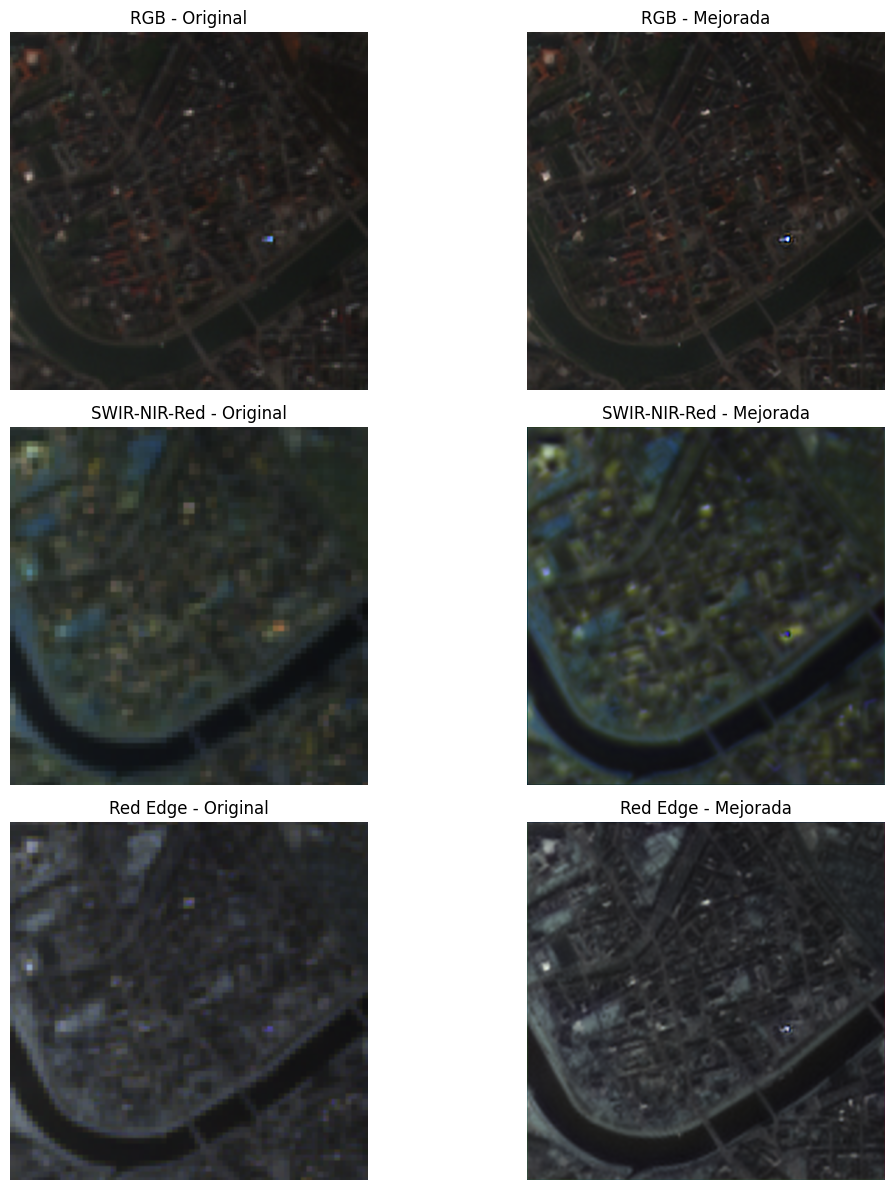

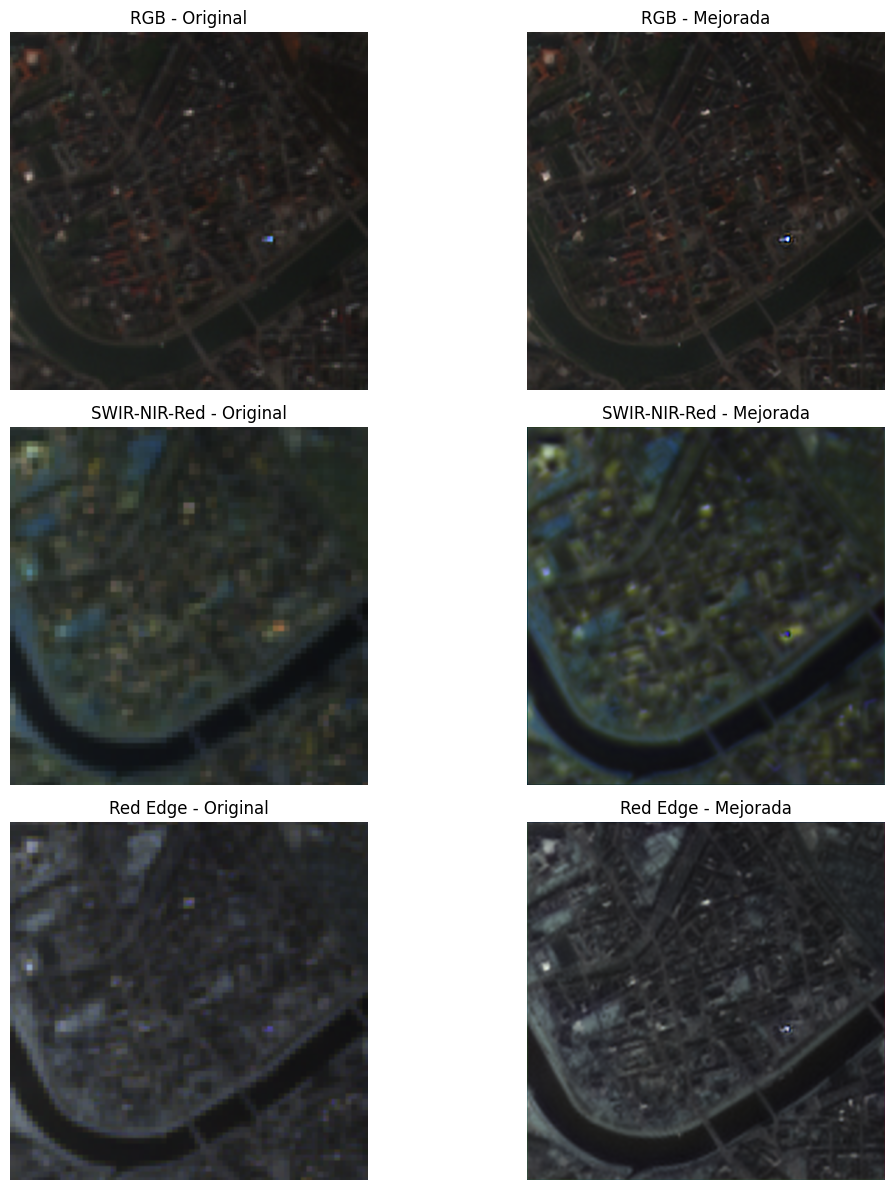

In [16]:
lr_slice = slice(32, 96)
hr_slice = slice(lr_slice.start*4, lr_slice.stop*4)
plot_sentinel2_comparison(X[:, :, :], superX[..., :, :])